In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Rohdaten importieren
excel_file_path = '2023_eim.xlsx'
all_sheets_dict = pd.read_excel(excel_file_path, sheet_name=None)

# leere Liste erstellen für die DataFrames
all_sheets_list = []

# Schleife über alle DataFrames in all_sheets_dict und diese in die Liste all_sheets_list einfügen
for sheet_name, sheet_df in all_sheets_dict.items():
    # Spalte 'Jahr' aus dem Sheet-Namen erstellen
    sheet_df['Jahr'] = sheet_name
    all_sheets_list.append(sheet_df)

# Zusammenführen der DataFrames in all_sheets_list zu einem DataFrame
combined_df = pd.concat(all_sheets_list, ignore_index=True)

# Speichern des DataFrames in eine Excel-Datei
combined_df.to_excel('2023_eim_combined.xlsx', index=False)

# Erstellen eines neuen DataFrames mit der Anzahl der einzigartigen Kunden und der Summe der Tage, gruppiert nach 'Mitarbeiter' und 'Jahr'
grouped_df = combined_df.groupby(['Mitarbeiter', 'Jahr']).agg(
    num_customers=pd.NamedAgg(column='Anforderer', aggfunc='nunique'),
    sum_tage=pd.NamedAgg(column='Tage', aggfunc='sum')
).reset_index()

# Speichern des gruppierten DataFrames in eine Excel-Datei
grouped_df.to_excel('2023_eim_grouped.xlsx', index=False)

Die gruppierten Daten dienen als Input für die weitere Aufbereitung der Daten, zu einer Excel Datei mit den Input Features.

In [492]:
# import input features
input_file_path = 'input_features.xlsx'

input_df = pd.read_excel(input_file_path)
arbeitstage = {2017: 247, 2018: 249, 2019: 249, 2020: 253, 2021: 253, 2022: 250, 2023: 248}
bip_deutschland = {2017: 2.7, 2018: 1, 2019: 1.1, 2020: -3.8, 2021: 3.2, 2022: 1.8, 2023: -0.3}
fis_turnover_per_employee = {2017: 98658, 2018: 102865, 2019: 104651, 2020: 107317, 2021: 109112, 2022: 111318, 2023: 114443}

# add column 'Arbeitstage' to the dataframe according to the column 'Jahr'
input_df['Arbeitstage'] = input_df['Jahr'].map(arbeitstage)
# add column 'BIP Deutschland' to the dataframe according to the column 'Jahr'
input_df['Wirtschaftswachstum'] = input_df['Jahr'].map(bip_deutschland)
# add column 'FIS Turnover per Employee' to the dataframe according to the column 'Jahr'
input_df['FIS Umsatz pro Mitarbeiter'] = input_df['Jahr'].map(fis_turnover_per_employee)
# multiply the column 'Vollzeit' with the column 'Arbeitstage' and add the result to the dataframe as column 'Workdays'
input_df['Workdays'] = input_df['Vollzeit'] * input_df['Arbeitstage']

# print the head of the dataframe
print(input_df.head())

   Jahr   Name  Alter  Berufserfahrung  Anzahl Kunden  Bestandskunden  Level  \
0  2017  BAERJ    NaN              NaN             45             NaN    NaN   
1  2018  BAERJ    NaN              NaN             48             NaN    NaN   
2  2019  BAERJ    NaN              NaN             54             NaN    NaN   
3  2020  BAERJ    NaN              NaN             50             NaN    NaN   
4  2021  BAERJ    NaN              NaN             36             NaN    NaN   

   Fehltage  Vollzeit  Potential  Backlog    Tage  Arbeitstage  \
0       NaN       NaN        NaN      NaN  112.17          247   
1       NaN       NaN        NaN      NaN  123.63          249   
2       NaN       NaN        NaN      NaN   74.69          249   
3       NaN       NaN        NaN      NaN  130.47          253   
4       NaN       NaN        NaN      NaN  132.96          253   

   Wirtschaftswachstum  FIS Umsatz pro Mitarbeiter  Workdays  
0                  2.7                       98658       Na

Kalkuliere welche Kunden die Berater in jeweiligen Jahr betreut haben.
Es soll nach Höhe des Aufwands geclustert werden.
Hat ein Berater einen Kunden mit mehr als 80 Tagen, so soll dieser Kunde in die Kategorie A fallen.
Hat ein Berater einen Kunden mit mehr als 40 Tagen, so soll dieser Kunde in die Kategorie B fallen.
Hat ein Berater einen Kunden mit weniger als 40 Tagen, so soll dieser Kunde in die Kategorie C fallen.
Hat ein Berater nur Kunden mit weniger als 10 Tagen soll diser in die Kategorie D fallen.

In [493]:
# based on the combined_df dataframe, create a new dataframe with the customers and the categories A, B, C, D per Name

# first filter the combined_df dataframe, select the highest value of 'Tage' for each 'Mitarbeiter' and 'Jahr'
customers_filtered_highest_df = combined_df.loc[combined_df.groupby(['Mitarbeiter', 'Jahr'])['Tage'].idxmax()]
# add a column 'Kategorie' to the dataframe
customers_filtered_highest_df['Kategorie'] = ''
# set 'Kategorie' to 'D' if 'Tage' is less than 10 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] <= 10, 'Kategorie'] = 0
# set 'Kategorie' to 'C' if 'Tage' is greater than 40 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 10, 'Kategorie'] = 1
# set 'Kategorie' to 'B' if 'Tage' is greater than 40 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 40, 'Kategorie'] = 2
# set 'Kategorie' to 'A' if 'Tage' is greater than 80 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 80, 'Kategorie'] = 3
# set 'Kategorie' to 'B' if 'Tage' is greater than 40 for the row in customers_filtered_highest_df

# save customers_filtered_highest_df to an excel file
customers_filtered_highest_df.to_excel('customers_filtered_highest.xlsx', index=False)


In [494]:
# Convert 'Jahr' to int (if it's safe to do so) in both DataFrames
input_df['Jahr'] = input_df['Jahr'].astype(int)
customers_filtered_highest_df['Jahr'] = customers_filtered_highest_df['Jahr'].astype(int)

# based on 'Name' and 'Jahr' join 'Kategorie' from customers_filtered_highest_df to input_df where 'Mitarbeiter' is equal to 'Name' and 'Jahr' is equal to 'Jahr'
input_df = input_df.merge(customers_filtered_highest_df[['Mitarbeiter', 'Jahr', 'Kategorie']], left_on=['Name', 'Jahr'], right_on=['Mitarbeiter', 'Jahr'], how='left')

# drop column 'Mitarbeiter' from input_df
input_df.drop(columns=['Mitarbeiter'], inplace=True)

# convert 'Kategorie' to int
input_df['Kategorie'] = input_df['Kategorie'].astype(int)


In [495]:
# filter the data in the dataframe input_df only to show data where alter is not NaN
input_df = input_df[input_df['Alter'].notna()]
print(input_df)

     Jahr      Name  Alter  Berufserfahrung  Anzahl Kunden  Bestandskunden  \
7    2017    BAUERS   31.0              5.0              9             0.0   
8    2018    BAUERS   32.0              6.0             17             0.0   
9    2019    BAUERS   33.0              7.0             13             0.0   
10   2020    BAUERS   34.0              8.0              8             0.0   
18   2022   BERGENR   30.0              1.0             14             1.0   
..    ...       ...    ...              ...            ...             ...   
236  2019  ZIEGLERP   34.0              7.0              9             0.0   
237  2020  ZIEGLERP   35.0              8.0              6             0.0   
238  2021  ZIEGLERP   36.0              9.0              4             0.0   
239  2022  ZIEGLERP   37.0             10.0              3             0.0   
240  2023  ZIEGLERP   38.0             11.0              5             0.0   

     Level  Fehltage  Vollzeit  Potential  Backlog    Tage  Arb

In [496]:
# save the dataframe to an excel file
input_df.to_excel('input_features_filtered.xlsx', index=False)

Aufbau eines Models mit den Input Features.
Jahr, Alter, Berufserfahrung, Anzahl Kunden, Bestandskunden
Die Target Variable ist die Variable Tage.

In [516]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# preprocess the data and apply scaling
numeric_features = ['Alter', 'Anzahl Kunden']
categorical_features = ['Bestandskunden', 'Level', 'Kategorie', 'Potential']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Prepare the data for training the model
#X = input_df[['Alter', 'Berufserfahrung', 'Anzahl Kunden', 'Bestandskunden', 'FIS Umsatz pro Mitarbeiter', 'Workdays', 'Level', 'Kategorie']]
X = input_df[['Alter', 'Anzahl Kunden', 'Bestandskunden', 'Level', 'Kategorie', 'Potential']]
y = input_df['Tage']

# Split the data into training and cross validation data - 80% training, 20% cross validation
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# create pipeline
model = make_pipeline(preprocessor, LinearRegression())

# Train the model
model.fit(X_train, y_train)

# save the model to disk
import pickle
filename = 'bt_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Evaluate the model with the cross validation data
y_pred_cv = model.predict(X_cv)
# Evaluate the model with the training data
y_pred_train = model.predict(X_train)

# Mean Squared Error with the cross validation data
mse_cv = mean_squared_error(y_cv, y_pred_cv)
# Mean Squared Error with the training data
mse_train = mean_squared_error(y_train, y_pred_train)
# Calculate the Mean Absolute Error with the cross validation data
mae_cv = np.mean(np.abs(y_cv - y_pred_cv))
# Calculate the Mean Absolute Error with the training data
mae_train = np.mean(np.abs(y_train - y_pred_train))
# Root Mean Squared Error with the cross validation data
rmse_cv = np.sqrt(mse_cv)
# Root Mean Squared Error with the training data
rmse_train = np.sqrt(mse_train)
print(f'Mean Squared Error CV: {mse_cv}')
print(f'Mean Absolute Error CV: {mae_cv}')
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Mean Squared Error Train: {mse_train}')
print(f'Mean Absolute Error Train: {mae_train}')
print(f'Root Mean Squared Error Train: {rmse_train}')

Mean Squared Error CV: 460.64982595875335
Mean Absolute Error CV: 17.685636449656553
Root Mean Squared Error CV: 21.462754388911815
Mean Squared Error Train: 244.84613244451785
Mean Absolute Error Train: 11.802765927948053
Root Mean Squared Error Train: 15.647559951778995


In [517]:
# print the y_cv and y_pred_cv values and compare them in a dataframe
output_df = pd.DataFrame({'y_cv': y_cv, 'y_pred_cv': y_pred_cv})
print(output_df)

# save the output_df to an excel file
output_df.to_excel('output.xlsx', index=False)

       y_cv   y_pred_cv
52   143.49  145.197392
129   58.27   55.959733
116  142.28  153.300791
178  147.35  143.273134
152   27.87   14.857374
193  133.17  115.827017
155   76.05   55.659623
239  155.09  145.641526
202  113.76  148.721081
18    78.71   36.483362
81    78.49  102.443951
232  143.47  150.187368
131   84.64   71.608890
205   28.19   58.431105
53   111.82  147.802969
179  150.03  143.731105
37    51.95   65.346723
210  162.85  122.222998
38    55.69   65.804694
230  119.76  142.341501
141  130.73  139.427035
180  148.85  138.849115
7    122.01  151.455071
73    98.43  104.094032
85    86.02  114.911074


In [520]:
# To get the output feature names
feature_names_transformed = model.named_steps['columntransformer'].get_feature_names_out()

print("Transformed Feature Names:")
print(feature_names_transformed)

X_transformed = preprocessor.transform(X_train)

# Create a DataFrame with the transformed data
transformed_df = pd.DataFrame(X_transformed, columns=feature_names_transformed)

# Export the DataFrame to a CSV file
transformed_df.to_csv('transformed_features.csv', index=False)

Transformed Feature Names:
['num__Alter' 'num__Anzahl Kunden' 'cat__Bestandskunden_0.0'
 'cat__Bestandskunden_1.0' 'cat__Level_1.0' 'cat__Level_2.0'
 'cat__Level_3.0' 'cat__Level_4.0' 'cat__Level_5.0' 'cat__Kategorie_0'
 'cat__Kategorie_1' 'cat__Kategorie_2' 'cat__Kategorie_3'
 'cat__Potential_0.0' 'cat__Potential_1.0' 'cat__Potential_2.0'
 'cat__Potential_3.0']


Try some regularization on the model to see if it improves the performance.

In [522]:
from sklearn.linear_model import Ridge

# Train the model with Ridge regularization
ridge_model = make_pipeline(preprocessor, Ridge(alpha=0.9))

ridge_model.fit(X_train, y_train)

# Evaluate the model with the cross validation data
y_pred_cv_ridge = ridge_model.predict(X_cv)
# Evaluate the model with the training data
y_pred_train_ridge = ridge_model.predict(X_train)

# Mean Squared Error with the cross validation data
mse_cv_ridge = mean_squared_error(y_cv, y_pred_cv_ridge)
# Mean Squared Error with the training data
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
# Calculate the Mean Absolute Error with the cross validation data
mae_cv_ridge = np.mean(np.abs(y_cv - y_pred_cv_ridge))
# Calculate the Mean Absolute Error with the training data
mae_train_ridge = np.mean(np.abs(y_train - y_pred_train_ridge))
# Root Mean Squared Error with the cross validation data
rmse_cv_ridge = np.sqrt(mse_cv_ridge)
# Root Mean Squared Error with the training data
rmse_train_ridge = np.sqrt(mse_train_ridge)

#compare the results of the linear regression model with the ridge model
#only compare the root mean squared error
print(".......................................................")
print("Results from the linear regression model:")
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Root Mean Squared Error Train: {rmse_train}')
print(".......................................................")
print("Results from the ridge model:")
print(f'Root Mean Squared Error CV Ridge: {rmse_cv_ridge}')
print(f'Root Mean Squared Error Train Ridge: {rmse_train_ridge}')



.......................................................
Results from the linear regression model:
Root Mean Squared Error CV: 21.462754388911815
Root Mean Squared Error Train: 15.647559951778995
.......................................................
Results from the ridge model:
Root Mean Squared Error CV Ridge: 21.021896352431114
Root Mean Squared Error Train Ridge: 15.761064892908518


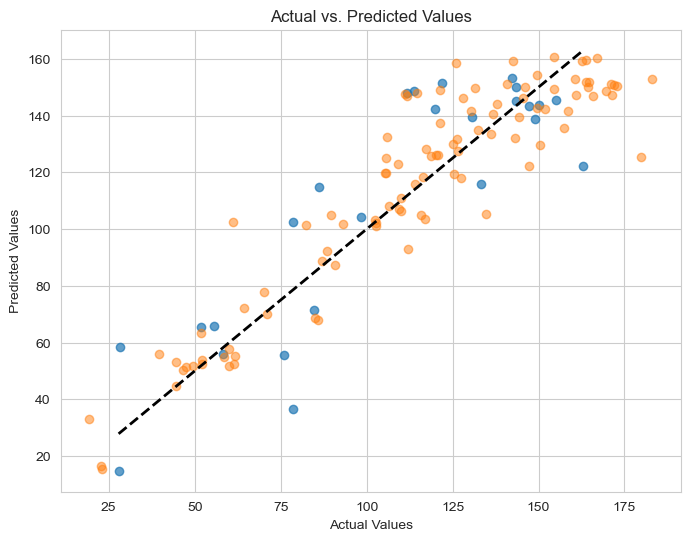

In [523]:
# visualize y_cv in blue and y_pred_cv in red in a scatter plot
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_cv, y_pred_cv, alpha=0.7)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_cv.min(), y_cv.max()], [y_cv.min(), y_cv.max()], 'k--', lw=2)  # Diagonal line
plt.show()


Zeige die Korellation der Input Features mit der Target Variable in je einem Scatter Plot.  

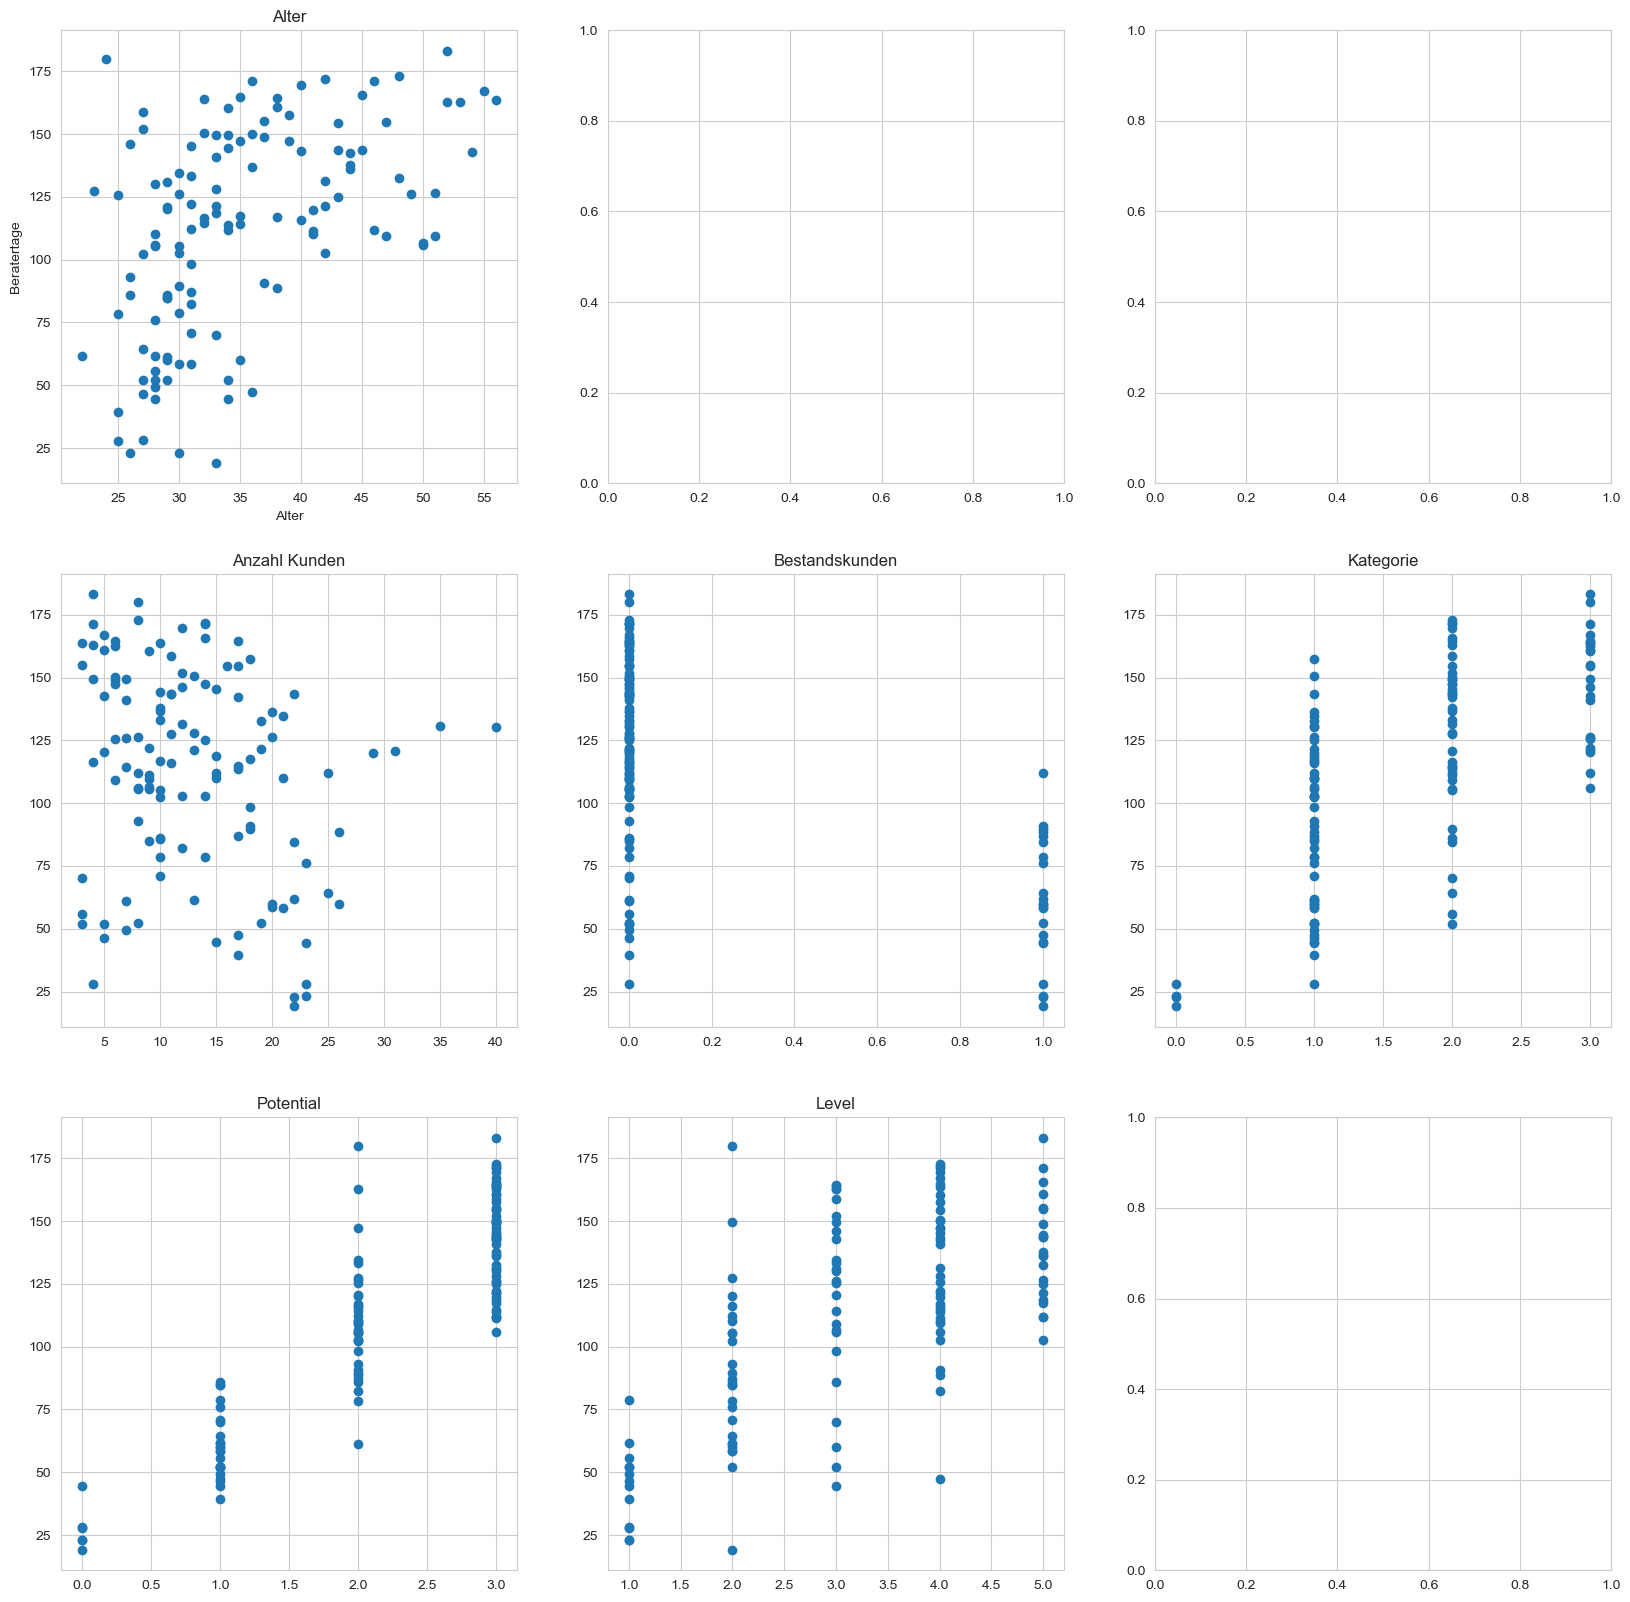

In [526]:
# show the correlation of the input features with the target variable in a scatter plot
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs[0, 0].scatter(X['Alter'], y)
axs[0, 0].set_title('Alter')
axs[0, 0].set_xlabel('Alter')
axs[0, 0].set_ylabel('Beratertage')
#axs[0, 1].boxplot(X['Potential'], y)
#axs[0, 1].set_title('Potential')
#axs[0, 2].scatter(X['Workdays'], y)
#axs[0, 2].set_title('Workdays')
axs[1, 0].scatter(X['Anzahl Kunden'], y)
axs[1, 0].set_title('Anzahl Kunden')
axs[1, 1].scatter(X['Bestandskunden'], y)
axs[1, 1].set_title('Bestandskunden')
axs[1, 2].scatter(X['Kategorie'], y)
axs[1, 2].set_title('Kategorie')
axs[2, 0].scatter(X['Potential'], y)
axs[2, 0].set_title('Potential')
axs[2, 1].scatter(X['Level'], y)
axs[2, 1].set_title('Level')

plt.show()

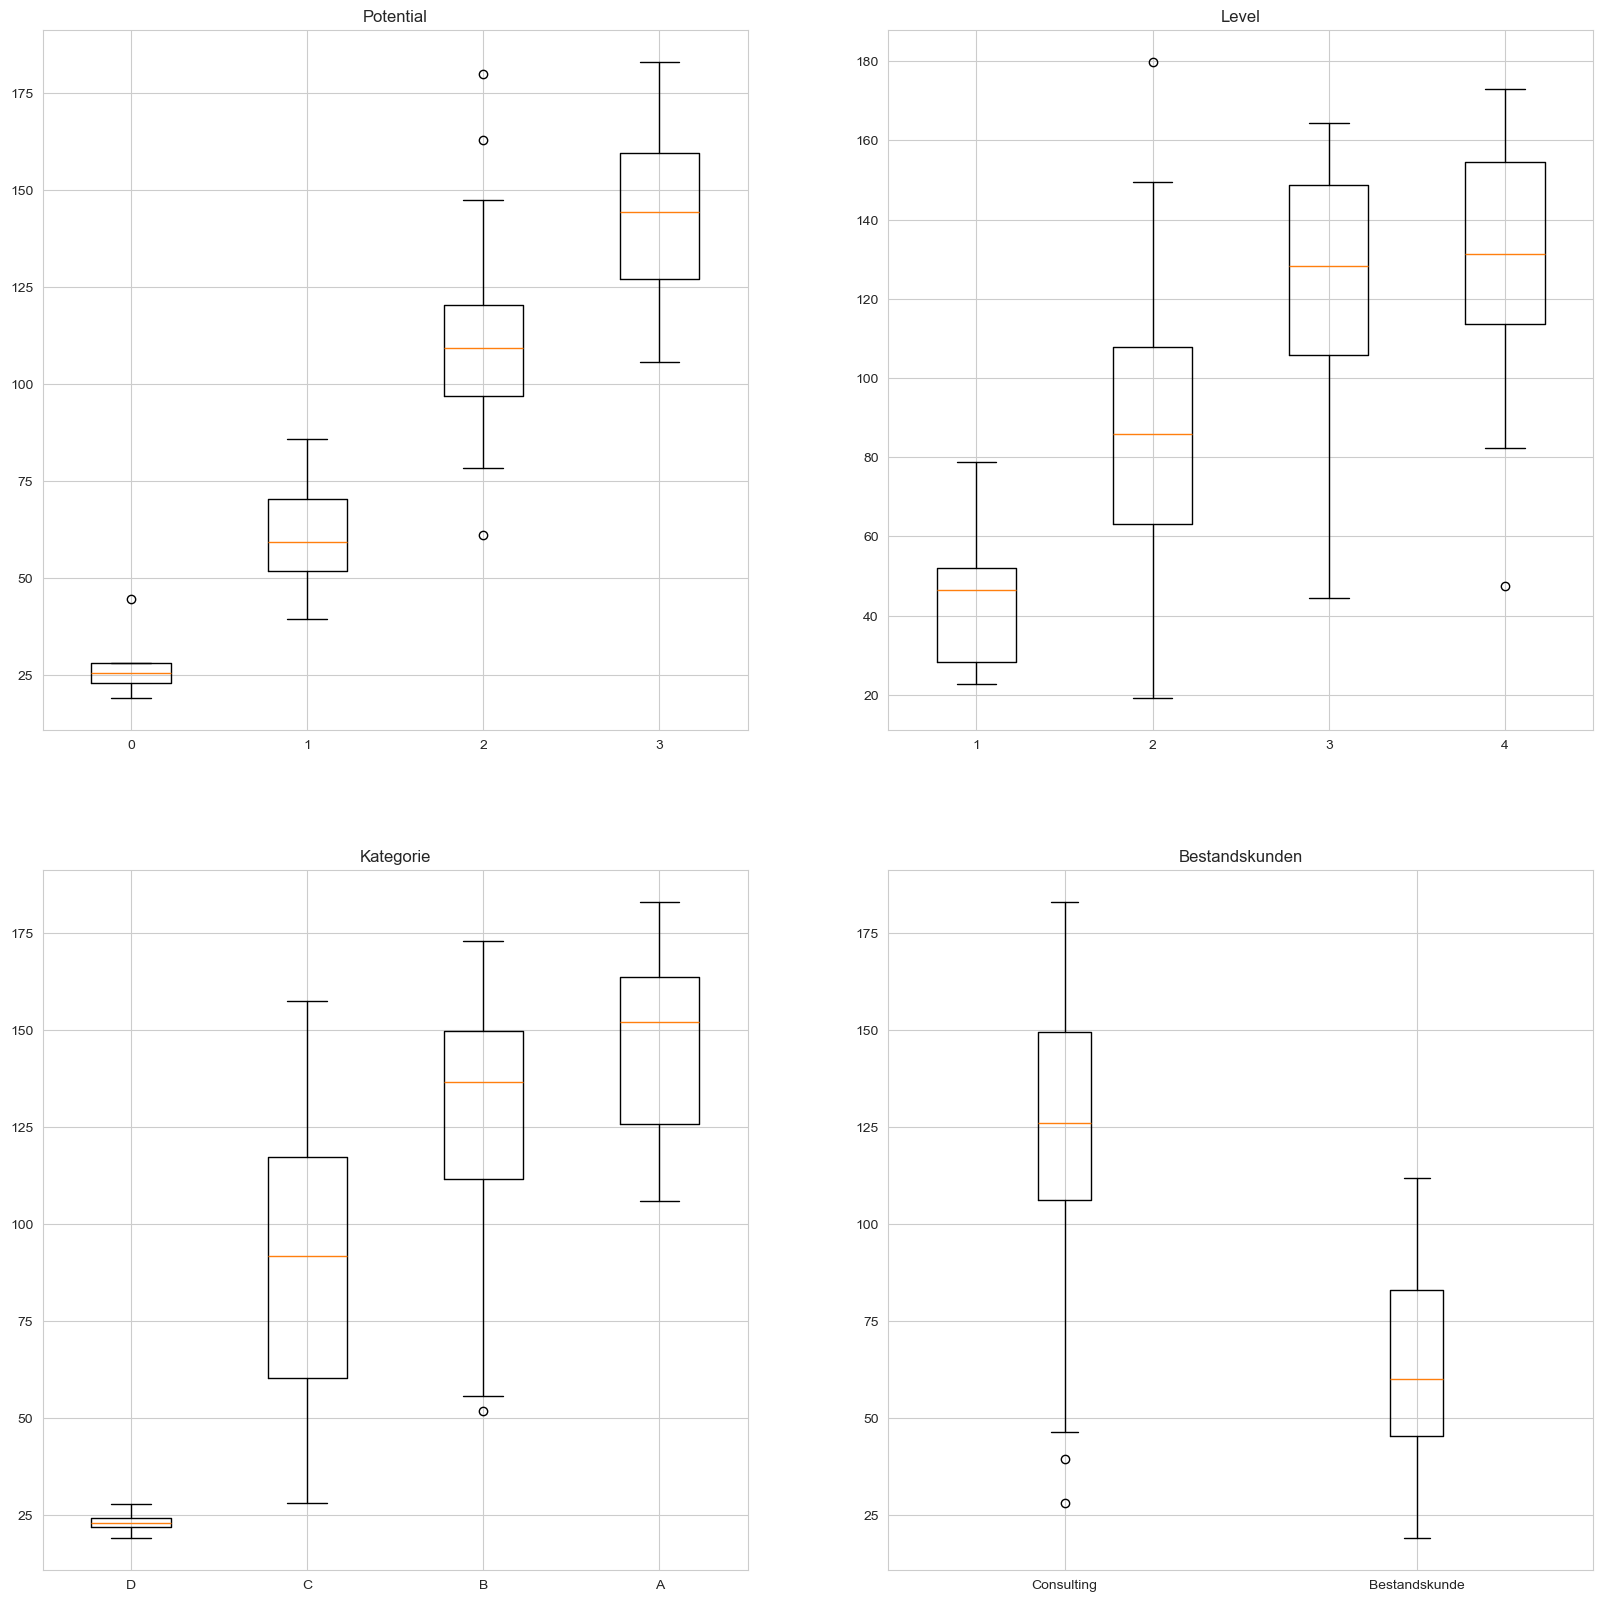

In [528]:
# create a boxplot of the input features with the target variable
# show the boxplot for 'Potential', 'Level', 'Kategorie' and 'Bestandskunden'
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# boxplot for 'Potential' which is a categorical variable with 4 levels from 0 to 3
axs[0, 0].boxplot([input_df[input_df['Potential'] == 0]['Tage'], input_df[input_df['Potential'] == 1]['Tage'], input_df[input_df['Potential'] == 2]['Tage'], input_df[input_df['Potential'] == 3]['Tage']])
axs[0, 0].set_title('Potential')
axs[0, 0].set_xticklabels(['0', '1', '2', '3'])
# boxplot for 'Level' which is a categorical variable with 4 levels from 1 to 4
axs[0, 1].boxplot([input_df[input_df['Level'] == 1]['Tage'], input_df[input_df['Level'] == 2]['Tage'], input_df[input_df['Level'] == 3]['Tage'], input_df[input_df['Level'] == 4]['Tage']])
axs[0, 1].set_title('Level')
axs[0, 1].set_xticklabels(['1', '2', '3', '4'])
# boxplot for 'Kategorie' which is a categorical variable with 4 levels from D to A
axs[1, 0].boxplot([input_df[input_df['Kategorie'] == 0]['Tage'], input_df[input_df['Kategorie'] == 1]['Tage'], input_df[input_df['Kategorie'] == 2]['Tage'], input_df[input_df['Kategorie'] == 3]['Tage']])
axs[1, 0].set_title('Kategorie')
axs[1, 0].set_xticklabels(['D', 'C', 'B', 'A'])
axs[1, 1].boxplot([input_df[input_df['Bestandskunden'] == 0]['Tage'], input_df[input_df['Bestandskunden'] == 1]['Tage']])
axs[1, 1].set_title('Bestandskunden')
axs[1, 1].set_xticklabels(['Consulting', 'Bestandskunde'])

plt.show()


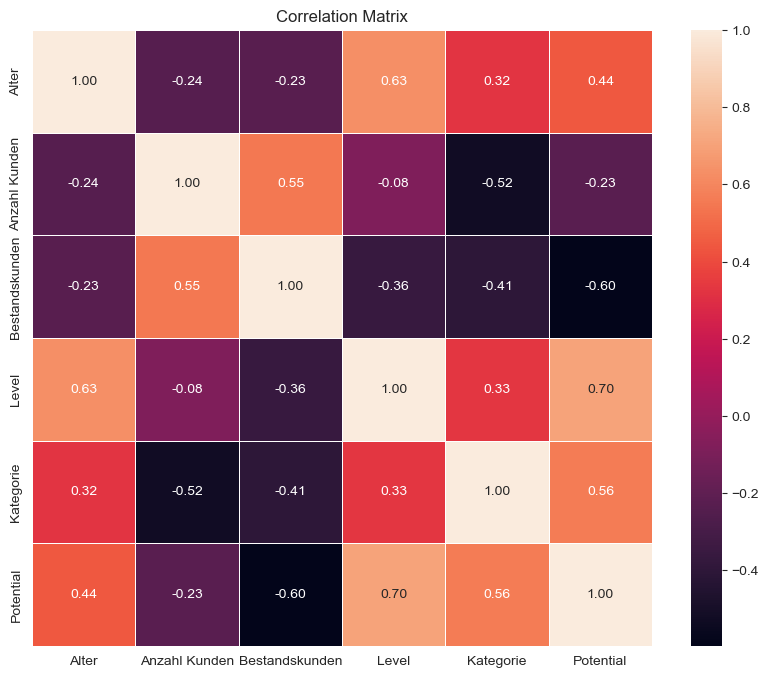

In [503]:
import seaborn as sns

correlation_matrix = X_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

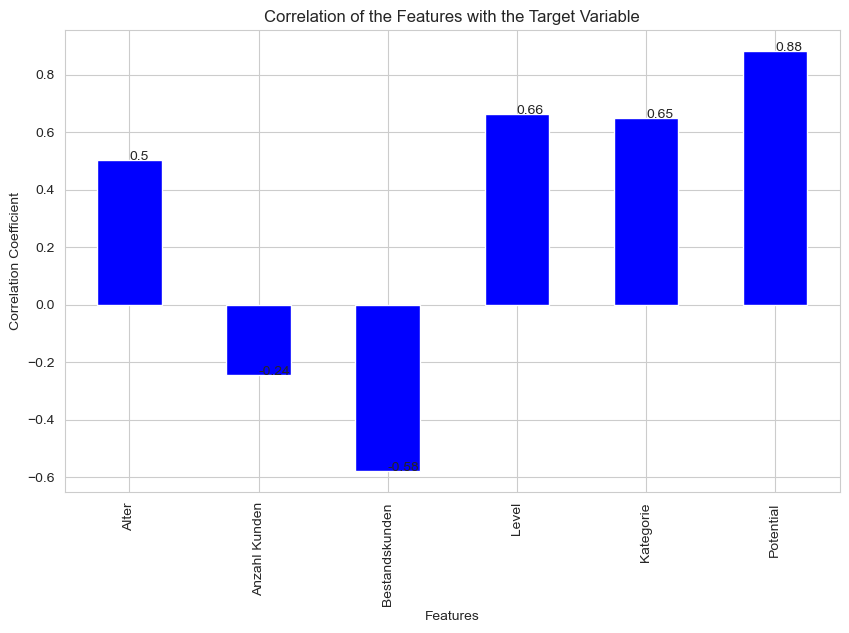

In [504]:
# Calculate correlation of each independent variable in X with the target variable y
correlation = X.corrwith(y)

# create a bar plot of the correlation of each independent variable with the target variable
plt.figure(figsize=(10, 6))
correlation.plot(kind='bar', color='blue')
# plot the values of each bar on the bar plot
for index, value in enumerate(correlation):
    plt.text(index, value, str(round(value, 2)))
plt.title('Correlation of the Features with the Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

In [505]:
# create a pearson correlation test
from scipy.stats import pearsonr

# calculate the pearson correlation coefficient and the p-value for the correlation for every feature within X
for column in X:
    corr, p = pearsonr(X[column], y)
    print(f'Pearsons correlation coefficient between {column} and y: {corr}')
    print(f'p-value: {p}')
    if p > 0.05:
        print('The correlation is not significant')
    else:
        print('The correlation is significant')
    print('.......................................................')

Pearsons correlation coefficient between Alter and y: 0.5044992094813084
p-value: 1.9880609496311334e-09
The correlation is significant
.......................................................
Pearsons correlation coefficient between Anzahl Kunden and y: -0.244388896075226
p-value: 0.006020198305195097
The correlation is significant
.......................................................
Pearsons correlation coefficient between Bestandskunden and y: -0.57949295664304
p-value: 1.4365736618721084e-12
The correlation is significant
.......................................................
Pearsons correlation coefficient between Level and y: 0.6620474657622447
p-value: 4.2176117530974073e-17
The correlation is significant
.......................................................
Pearsons correlation coefficient between Kategorie and y: 0.64892270887354
p-value: 2.7500773723563656e-16
The correlation is significant
.......................................................
Pearsons correlation coe

# Neuronales Netz
Nachdem das Model mit Hilfe von Linearer Regression erstellt wurde, wird nun ein Model mit Hilfe eines neuronalen Netzes erstellt.

In [506]:
import tensorflow as tf
#from sklearn.preprocessing import StandardScaler
import keras
from keras import layers

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Split the data into training and cross validation data - 80% training, 20% cross validation
X_train_nn, X_cv_nn, y_train_nn, y_cv_nn = train_test_split(X, y, test_size=0.2, random_state=42)

print(
    f"Using {len(X_train_nn)} records for training "
    f"and {len(X_cv_nn)} records for cross validation")
# print all data types of X_train_nn
print(X_train_nn.dtypes)

Using 100 records for training and 25 records for cross validation
Alter             float64
Anzahl Kunden       int64
Bestandskunden    float64
Level             float64
Kategorie           int64
Potential         float64
dtype: object


In [507]:
# build the neural network model
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

# compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# train the model
# stop training when the validation loss metric has stopped decreasing for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

nn_model.fit(X_train_nn, y_train_nn, epochs=120, batch_size=1, validation_data=(X_cv_nn, y_cv_nn))


Epoch 1/120
100/100 [==============================] - 0s 801us/step - loss: 7102.7119 - mean_absolute_error: 75.5863 - val_loss: 2257.7510 - val_mean_absolute_error: 39.5825
Epoch 2/120
100/100 [==============================] - 0s 395us/step - loss: 1926.3601 - mean_absolute_error: 35.8440 - val_loss: 954.8362 - val_mean_absolute_error: 24.9633
Epoch 3/120
100/100 [==============================] - 0s 381us/step - loss: 1398.5085 - mean_absolute_error: 30.5010 - val_loss: 851.7795 - val_mean_absolute_error: 23.7847
Epoch 4/120
100/100 [==============================] - 0s 383us/step - loss: 1326.8441 - mean_absolute_error: 30.0067 - val_loss: 816.6499 - val_mean_absolute_error: 23.7755
Epoch 5/120
100/100 [==============================] - 0s 381us/step - loss: 1266.7074 - mean_absolute_error: 29.0444 - val_loss: 757.2715 - val_mean_absolute_error: 23.0135
Epoch 6/120
100/100 [==============================] - 0s 381us/step - loss: 1225.0309 - mean_absolute_error: 28.6174 - val_loss:

In [508]:
# evaluate the model with the cross validation data
print("Results for the cross validation data:")
print(nn_model.evaluate(X_cv_nn, y_cv_nn))

# evaluate the model with the training data
print("Results for the training data:")
print(nn_model.evaluate(X_train_nn, y_train_nn))

print(".......................................................")
print("Results from the linear regression model:")
print(f'Mean Squared Error CV: {mse_cv}')
print(f'Mean Absolute Error CV: {mae_cv}')
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Mean Squared Error Train: {mse_train}')
print(f'Mean Absolute Error Train: {mae_train}')
print(f'Root Mean Squared Error Train: {rmse_train}')

Results for the cross validation data:
1/1 [==============================] - 0s 37ms/step - loss: 427.2500 - mean_absolute_error: 17.2986
[427.2500305175781, 17.298585891723633]
Results for the training data:
4/4 [==============================] - 0s 654us/step - loss: 296.6252 - mean_absolute_error: 13.5107
[296.62518310546875, 13.510685920715332]
.......................................................
Results from the linear regression model:
Mean Squared Error CV: 398.48729335526065
Mean Absolute Error CV: 16.43024768976292
Root Mean Squared Error CV: 19.962146511717137
Mean Squared Error Train: 275.2308139576644
Mean Absolute Error Train: 12.708449225329439
Root Mean Squared Error Train: 16.59008179478523


In [ ]:
# save the tensorflow model to disk
nn_model.save('tf_bt_model.keras')